# Notebook Contents

- [Imports](#Imports)
- [Data](#Data)
- [Data Cleaning](#Data-Cleaning)
- [Preprocessing](#Preprocessing)
    - [Multicolinearity - VIF](#Multicolinearity---VIF)
- [Features](#Features)
- [Linear Regression](#Linear-Regression-Model)
    - [4-Seam RHP](#4-Seam-RHP)
    - [4-Seam LHP](#4-Seam-LHP)
    - [Cutter RHP](#Cutter-RHP)
    - [Cutter LHP](#Cutter-LHP)
    - [Sinker RHP](#Sinker-RHP)
    - [Sinker LHP](#Sinker-LHP)
    - [Slider RHP](#Slider-RHP)
    - [Slider LHP](#Slider-LHP)
    - [Curveball RHP](#Curveball-RHP)
    - [Curveball LHP](#Curveball-LHP)
    - [Changeup RHP](#Changeup-RHP)
    - [Changeup LHP](#Changeup-LHP)
    - [Grouped Pitches](#Grouped-Pitches)
    - [Fastball RHP](#Fastball-RHP)
    - [Fastball LHP](#Fastball-LHP)
    - [Breaking Ball RHP](#Breaking-Ball-RHP)
    - [Breaking Ball LHP](#Breaking-Ball-LHP)
    - [Off-Speed RHP](#Off-speed-RHP)
    - [Off-Speed LHP](#Off-speed-LHP)

# Imports

In [1]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

# Data

In [2]:
data = pd.read_csv('../data/model-pitches-rv.csv', index_col = [0])
pd.set_option('max_columns', None)
print(data.shape)
data.head()

(705403, 57)


,player_name,p_throws,pitch_type,velo,spin_rate,spin_axis,pfx_-x,pfx_z,bauer_units,effective_speed,release_pos_x,release_pos_z,release_extension,release_pos_y,plate_-x,plate_x,plate_z,type,balls,strikes,pitch_count,stand,description,events,hit_distance_sc,exit_velo,launch_angle,launch_speed_angle,xba,xwobacon,woba_value,woba_denom,babip_value,iso_value,at_bat_number,pitch_number,inning,inning_topbot,home_score,away_score,post_home_score,post_away_score,on_1b,on_2b,on_3b,outs_when_up,delta_run_exp,home_runs,away_runs,runs,re,re_end_state,re24,count_woba_value,count_woba_diff,count_woba_after,rv_count
0,"Smith, Will",L,FF,92.3,2330.0,148.0,-8.28,16.56,25.243770,92.8,1.40,6.80,6.5,54.03,0.69,-0.69,2.83,X,1,2,1-2,R,hit_into_play,field_out,13.0,95.2,-13.0,2.0,0.174,0.158,0.0,1.0,0.0,0.0,61,4,9,0,5,0,5,0,0,0,0,2,-0.073,0,0,0,0.115,0.042,-0.073,0.233,0.000,0.000,0.000
1,"Smith, Will",L,SL,80.6,2254.0,315.0,9.24,5.76,27.965261,81.2,1.60,6.64,6.4,54.15,0.71,-0.71,2.62,S,1,1,1-1,R,foul,NaN,108.0,75.3,75.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,61,3,9,0,5,0,5,0,0,0,0,2,-0.027,0,0,0,0.115,0.088,-0.027,0.313,-0.080,0.233,-0.070
2,"Smith, Will",L,CU,75.5,1940.0,328.0,7.80,-6.12,25.695364,75.2,1.46,6.88,6.2,54.34,0.04,-0.04,2.46,S,1,0,1-0,R,foul,NaN,157.0,83.5,65.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,61,2,9,0,5,0,5,0,0,0,0,2,-0.020,0,0,0,0.115,0.095,-0.020,0.374,-0.061,0.313,-0.053
3,"Smith, Will",L,CU,75.0,2017.0,330.0,8.28,-8.28,26.893333,74.5,1.53,6.83,5.9,54.61,-2.10,2.10,3.89,B,0,0,0-0,R,ball,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,61,1,9,0,5,0,5,0,0,0,0,2,0.016,0,0,0,0.115,0.131,0.016,0.331,0.043,0.374,0.037
4,"Smith, Will",L,FF,91.2,2281.0,143.0,-7.56,15.36,25.010965,90.9,1.49,6.66,6.3,54.15,0.31,-0.31,2.80,X,1,0,1-0,L,hit_into_play,field_out,9.0,93.3,-18.0,2.0,0.100,0.090,0.0,1.0,0.0,0.0,60,2,9,0,5,0,5,0,0,0,0,1,-0.189,0,0,0,0.298,0.109,-0.189,0.374,-0.043,0.331,-0.037


In [3]:
#lin_weight = data['re24'].mean()
#data['lin_weight'] = lin_weight
#data.head()

Using this wOBA by count, we can calculate the value of points scored by count.

(count wOBA after pitching – count wOBA before pitching) / wOBAscale (≈1.15 in Statcast csv data)

First, when the count changes, the actual RAA is calculated as:

(wOBA of the count after the pitch – wOBA of the count before the pitch) / 1.15

If a batted ball occurs, then this is used to calculate RAA:

(xwOBAvalue – wOBA of the count before the pitch) / wOBAscale

# Preprocessing

### Multicolinearity - VIF
**Independent Variables:** Velocity, Spin Rate, VB, HB, Release Extension, Horizontal Release Position, Vertical Release Position, Horizontal Plate Coords, Vertical Plate Coords

**Dependent Variable:** rv_count

In [4]:
features = data[['velo', 'spin_rate', 'pfx_-x', 'pfx_z', 'release_extension', 
                 'release_pos_x', 'release_pos_z', 'plate_x', 'plate_z', 'rv_count',
                 'pitch_type', 'p_throws', 'stand']]

features_vif = features.select_dtypes([np.number])
vif_data = pd.DataFrame()
vif_data["feature"] = features_vif.columns

vif_data["VIF"] = [variance_inflation_factor(features_vif.values, i)
                   for i in range(len(features_vif.columns))]

vif_data.sort_values(by = 'VIF').head(10)

,feature,VIF
9,rv_count,1.011577
7,plate_x,1.110665
5,release_pos_x,1.454784
2,pfx_-x,1.466136
3,pfx_z,3.125169
8,plate_z,7.462887
1,spin_rate,50.832560
6,release_pos_z,103.379774
4,release_extension,152.725687
0,velo,277.711423


# Features

In [5]:
zero_outs = data.loc[data['outs_when_up'] == 0]
print('0 outs:', zero_outs.shape)
one_out = data.loc[data['outs_when_up'] == 1]
print('1 out:', one_out.shape)
two_outs = data.loc[data['outs_when_up'] == 2]
print('2 outs:', two_outs.shape)

0 outs: (244451, 57)
1 out: (232568, 57)
2 outs: (228384, 57)


In [6]:
ff = features.loc[features['pitch_type'] == 'FF']
fc = features.loc[features['pitch_type'] == 'FC']
fastball = ff.append(fc)
si = features.loc[features['pitch_type'] == 'SI']
fastball = fastball.append(si)
print('Fastball shape:', fastball.shape)
sl = features.loc[features['pitch_type'] == 'SL']
cu = features.loc[features['pitch_type'] == 'CU']
breaking_ball = sl.append(cu)
kc = features.loc[features['pitch_type'] == 'KC']
breaking_ball = breaking_ball.append(kc)
print('Breaking Ball:', breaking_ball.shape)
ch = features.loc[features['pitch_type'] == 'CH']
fs = features.loc[features['pitch_type'] == 'FS']
offspeed = ch.append(fs)
print('Off speed shape:', offspeed.shape)
rhp = features.loc[features['p_throws'] == 'R']
print('RHP shape:', rhp.shape)
lhp = features.loc[features['p_throws'] == 'L']
print('LHP shape:', lhp.shape)
rhp_rhh = features.loc[(features['p_throws'] == 'R') & (features['stand'] == 'R')]
print('RHP & RHH shape:', rhp_rhh.shape)
rhp_lhh = features.loc[(features['p_throws'] == 'R') & (features['stand'] == 'L')]
print('RHP & LHH shape:', rhp_lhh.shape)
lhp_rhh = features.loc[(features['p_throws'] == 'L') & (features['stand'] == 'R')]
print('LHP & RHH shape:', lhp_rhh.shape)
lhp_lhh = features.loc[(features['p_throws'] == 'L') & (features['stand'] == 'L')]
print('LHP & LHH shape:', lhp_lhh.shape)
rhp_fastball = fastball.loc[fastball['p_throws'] == 'R']
print('RHP Fastball shape:', rhp_fastball.shape)
lhp_fastball = fastball.loc[fastball['p_throws'] == 'L']
print('LHP Fastball shape:', lhp_fastball.shape)
rhp_breaking_ball = breaking_ball.loc[breaking_ball['p_throws'] == 'R']
print('RHP Breaking Ball shape:', rhp_breaking_ball.shape)
lhp_breaking_ball = breaking_ball.loc[breaking_ball['p_throws'] == 'L']
print('LHP Breaking Ball shape:', lhp_breaking_ball.shape)
rhp_offspeed = offspeed.loc[offspeed['p_throws'] == 'R']
print('RHP Offspeed shape:', rhp_offspeed.shape)
lhp_offspeed = offspeed.loc[offspeed['p_throws'] == 'L']
print('LHP Offspeed shape:', lhp_offspeed.shape)

Fastball shape: (406259, 13)
Breaking Ball: (207982, 13)
Off speed shape: (91162, 13)
RHP shape: (496498, 13)
LHP shape: (208905, 13)
RHP & RHH shape: (267548, 13)
RHP & LHH shape: (228950, 13)
LHP & RHH shape: (149824, 13)
LHP & LHH shape: (59081, 13)
RHP Fastball shape: (283224, 13)
LHP Fastball shape: (123035, 13)
RHP Breaking Ball shape: (152383, 13)
LHP Breaking Ball shape: (55599, 13)
RHP Offspeed shape: (60891, 13)
LHP Offspeed shape: (30271, 13)


In [7]:
ff_r = rhp.loc[rhp['pitch_type'] == 'FF']
ff_l = lhp.loc[lhp['pitch_type'] == 'FF']
fc_r = rhp.loc[rhp['pitch_type'] == 'FC']
fc_l = lhp.loc[lhp['pitch_type'] == 'FC']
si_r = rhp.loc[rhp['pitch_type'] == 'SI']
si_l = lhp.loc[lhp['pitch_type'] == 'SI']
sl_r = rhp.loc[rhp['pitch_type'] == 'SL']
sl_l = lhp.loc[lhp['pitch_type'] == 'SL']
cu_r = rhp.loc[rhp['pitch_type'] == 'CU']
cu_l = lhp.loc[lhp['pitch_type'] == 'CU']
ch_r = rhp.loc[rhp['pitch_type'] == 'CH']
ch_l = lhp.loc[lhp['pitch_type'] == 'CH']

# Linear Regression Model

## 4-Seam RHP 

In [8]:
features_ff_r = ff_r.select_dtypes([np.number])
X = features_ff_r.drop(columns = ['rv_count'])
X = sm.add_constant(X)
y = features_ff_r['rv_count']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 10)

ols_ff_r = sm.OLS(y_train, X_train).fit()
pred_ff_r = ols_ff_r.predict(X_test)
pred = ols_ff_r.predict(X_train)
fitted_vals_ff_r = ols_ff_r.fittedvalues
residuals_ff_r = ols_ff_r.resid

print('MSE:', round(metrics.mean_squared_error(y_test, pred_ff_r), 4))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_ff_r)), 4))
print('MAE:', round(metrics.mean_absolute_error(y_test, pred_ff_r), 4))
print('Train MSE:', round(metrics.mean_squared_error(y_train, pred), 4))
print('Train RMSE:', round(np.sqrt(metrics.mean_squared_error(y_train, pred)), 4))
print('Train MAE:', round(metrics.mean_absolute_error(y_train, pred), 4))
print(ols_ff_r.summary())

MSE: 0.0036
RMSE: 0.0603
MAE: 0.0507
Train MSE: 0.0036
Train RMSE: 0.0602
Train MAE: 0.0506
                            OLS Regression Results                            
Dep. Variable:               rv_count   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     307.2
Date:                Wed, 09 Mar 2022   Prob (F-statistic):               0.00
Time:                        14:38:21   Log-Likelihood:             1.8405e+05
No. Observations:              132282   AIC:                        -3.681e+05
Df Residuals:                  132272   BIC:                        -3.680e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------

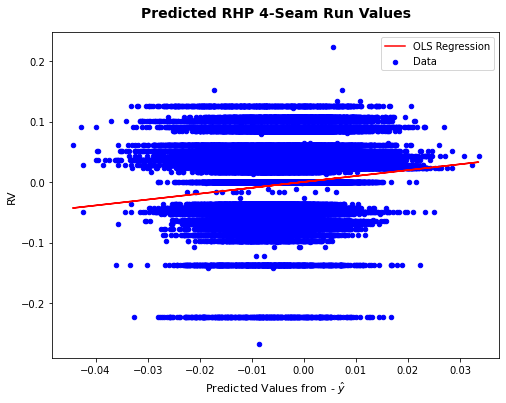

In [9]:
plt.figure(figsize = (8, 6))

plt.scatter(pred_ff_r, y_test, s = 20, c = 'b', marker = 'o', label = 'Data')
plt.plot(pred_ff_r, np.poly1d(np.polyfit(pred_ff_r, y_test, 1))(pred_ff_r), c = 'r', label = 'OLS Regression')
plt.legend()
plt.xlabel('Predicted Values from - $\hat{y}$', fontsize = 11), plt.ylabel('RV', fontsize = 11)
plt.title('Predicted RHP 4-Seam Run Values', fontsize = 14, fontweight = 'bold', pad = 15);

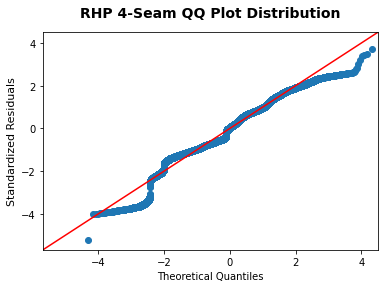

In [10]:
sm.qqplot(residuals_ff_r, line = '45', fit = True)
plt.ylabel('Standardized Residuals', fontsize = 11)
plt.title('RHP 4-Seam QQ Plot Distribution', fontsize = 14, fontweight = 'bold', pad = 15);

## 4-Seam LHP

In [11]:
features_ff_l = ff_l.select_dtypes([np.number])
X = features_ff_l.drop(columns = ['rv_count'])
X = sm.add_constant(X)
y = features_ff_l['rv_count']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 10)

ols_ff_l = sm.OLS(y_train, X_train).fit()
pred_ff_l = ols_ff_l.predict(X_test)
pred = ols_ff_l.predict(X_train)
fitted_vals_ff_l = ols_ff_l.fittedvalues
residuals_ff_l = ols_ff_l.resid

print('MSE:', round(metrics.mean_squared_error(y_test, pred_ff_l), 4))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_ff_l)), 4))
print('MAE:', round(metrics.mean_absolute_error(y_test, pred_ff_l), 4))
print('Train MSE:', round(metrics.mean_squared_error(y_train, pred), 4))
print('Train RMSE:', round(np.sqrt(metrics.mean_squared_error(y_train, pred)), 4))
print('Train MAE:', round(metrics.mean_absolute_error(y_train, pred), 4))
print(ols_ff_l.summary())

MSE: 0.0036
RMSE: 0.0602
MAE: 0.0507
Train MSE: 0.0037
Train RMSE: 0.0606
Train MAE: 0.0511
                            OLS Regression Results                            
Dep. Variable:               rv_count   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     103.3
Date:                Wed, 09 Mar 2022   Prob (F-statistic):          1.00e-192
Time:                        14:38:22   Log-Likelihood:                 76082.
No. Observations:               54977   AIC:                        -1.521e+05
Df Residuals:                   54967   BIC:                        -1.521e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------

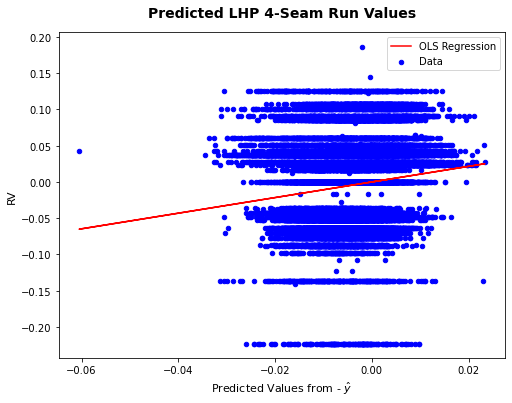

In [12]:
plt.figure(figsize = (8, 6))

plt.scatter(pred_ff_l, y_test, s = 20, c = 'b', marker = 'o', label = 'Data')
plt.plot(pred_ff_l, np.poly1d(np.polyfit(pred_ff_l, y_test, 1))(pred_ff_l), c = 'r', label = 'OLS Regression')
plt.legend()
plt.xlabel('Predicted Values from - $\hat{y}$', fontsize = 11), plt.ylabel('RV', fontsize = 11)
plt.title('Predicted LHP 4-Seam Run Values', fontsize = 14, fontweight = 'bold', pad = 15);

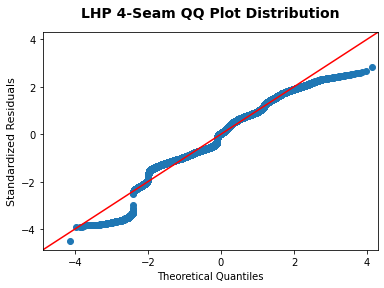

In [13]:
sm.qqplot(residuals_ff_l, line = '45', fit = True)
plt.ylabel('Standardized Residuals', fontsize = 11)
plt.title('LHP 4-Seam QQ Plot Distribution', fontsize = 14, fontweight = 'bold', pad = 15);

## Cutter RHP

In [14]:
features_fc_r = fc_r.select_dtypes([np.number])
X = features_fc_r.drop(columns = ['rv_count'])
X = sm.add_constant(X)
y = features_fc_r['rv_count']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 10)

ols_fc_r = sm.OLS(y_train, X_train).fit()
pred_fc_r = ols_fc_r.predict(X_test)
pred = ols_fc_r.predict(X_train)
fitted_vals_fc_r = ols_fc_r.fittedvalues
residuals_fc_r = ols_fc_r.resid

print('MSE:', round(metrics.mean_squared_error(y_test, pred_fc_r), 4))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_fc_r)), 4))
print('MAE:', round(metrics.mean_absolute_error(y_test, pred_fc_r), 4))
print('Train MSE:', round(metrics.mean_squared_error(y_train, pred), 4))
print('Train RMSE:', round(np.sqrt(metrics.mean_squared_error(y_train, pred)), 4))
print('Train MAE:', round(metrics.mean_absolute_error(y_train, pred), 4))
print(ols_fc_r.summary())

MSE: 0.0033
RMSE: 0.0578
MAE: 0.0495
Train MSE: 0.0033
Train RMSE: 0.0577
Train MAE: 0.0497
                            OLS Regression Results                            
Dep. Variable:               rv_count   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     62.10
Date:                Wed, 09 Mar 2022   Prob (F-statistic):          3.44e-113
Time:                        14:38:22   Log-Likelihood:                 33543.
No. Observations:               23385   AIC:                        -6.707e+04
Df Residuals:                   23375   BIC:                        -6.699e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------

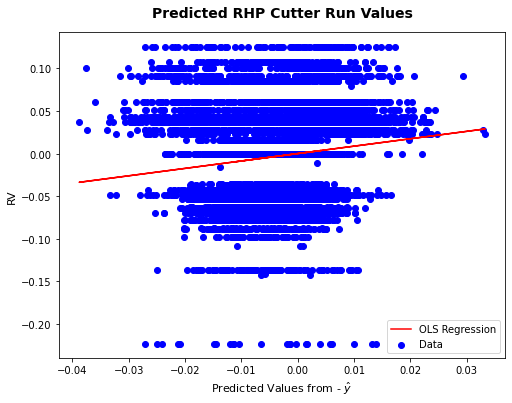

In [15]:
plt.figure(figsize = (8, 6))

plt.scatter(pred_fc_r, y_test, c = 'b', marker = 'o', label = 'Data')
plt.plot(pred_fc_r, np.poly1d(np.polyfit(pred_fc_r, y_test, 1))(pred_fc_r), c = 'r', label = 'OLS Regression')
plt.legend()
plt.xlabel('Predicted Values from - $\hat{y}$', fontsize = 11), plt.ylabel('RV', fontsize = 11)
plt.title('Predicted RHP Cutter Run Values', fontsize = 14, fontweight = 'bold', pad = 15);

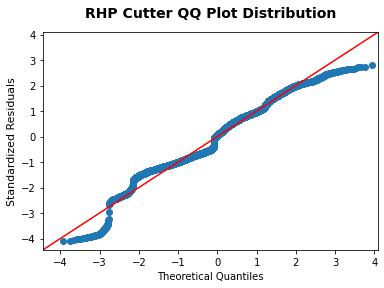

In [16]:
sm.qqplot(residuals_fc_r, line = '45', fit = True)
plt.ylabel('Standardized Residuals', fontsize = 11)
plt.title('RHP Cutter QQ Plot Distribution', fontsize = 14, fontweight = 'bold', pad = 15);

## Cutter LHP

In [17]:
features_fc_l = fc_l.select_dtypes([np.number])
X = features_fc_l.drop(columns = ['rv_count'])
X = sm.add_constant(X)
y = features_fc_l['rv_count']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 10)

ols_fc_l = sm.OLS(y_train, X_train).fit()
pred_fc_l = ols_fc_l.predict(X_test)
pred = ols_fc_l.predict(X_train)
fitted_vals_fc_l = ols_fc_l.fittedvalues
residuals_fc_l = ols_fc_l.resid

print('MSE:', round(metrics.mean_squared_error(y_test, pred_fc_l), 4))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_fc_l)), 4))
print('MAE:', round(metrics.mean_absolute_error(y_test, pred_fc_l), 4))
print('Train MSE:', round(metrics.mean_squared_error(y_train, pred), 4))
print('Train RMSE:', round(np.sqrt(metrics.mean_squared_error(y_train, pred)), 4))
print('Train MAE:', round(metrics.mean_absolute_error(y_train, pred), 4))
print(ols_fc_l.summary())

MSE: 0.0033
RMSE: 0.0573
MAE: 0.0496
Train MSE: 0.0033
Train RMSE: 0.0572
Train MAE: 0.0496
                            OLS Regression Results                            
Dep. Variable:               rv_count   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     11.97
Date:                Wed, 09 Mar 2022   Prob (F-statistic):           5.30e-19
Time:                        14:38:23   Log-Likelihood:                 17591.
No. Observations:               12196   AIC:                        -3.516e+04
Df Residuals:                   12186   BIC:                        -3.509e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------

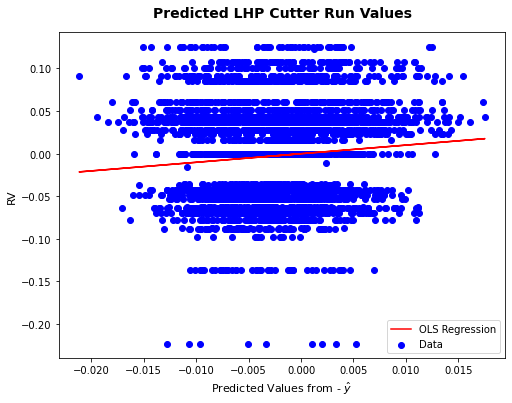

In [18]:
plt.figure(figsize = (8, 6))

plt.scatter(pred_fc_l, y_test, c = 'b', marker = 'o', label = 'Data')
plt.plot(pred_fc_l, np.poly1d(np.polyfit(pred_fc_l, y_test, 1))(pred_fc_l), c = 'r', label = 'OLS Regression')
plt.legend()
plt.xlabel('Predicted Values from - $\hat{y}$', fontsize = 11), plt.ylabel('RV', fontsize = 11)
plt.title('Predicted LHP Cutter Run Values', fontsize = 14, fontweight = 'bold', pad = 15);

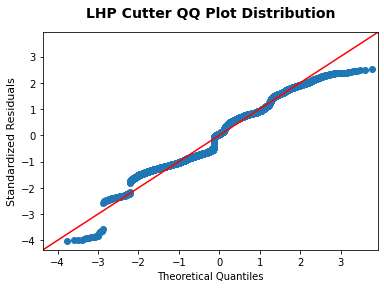

In [19]:
sm.qqplot(residuals_fc_l, line = '45', fit = True)
plt.ylabel('Standardized Residuals', fontsize = 11)
plt.title('LHP Cutter QQ Plot Distribution', fontsize = 14, fontweight = 'bold', pad = 15);

## Sinker RHP

In [20]:
features_si_r = si_r.select_dtypes([np.number])
X = features_si_r.drop(columns = ['rv_count'])
X = sm.add_constant(X)
y = features_si_r['rv_count']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 10)

ols_si_r = sm.OLS(y_train, X_train).fit()
pred_si_r = ols_si_r.predict(X_test)
pred = ols_si_r.predict(X_train)
fitted_vals_si_r = ols_si_r.fittedvalues
residuals_si_r = ols_si_r.resid

print('MSE:', round(metrics.mean_squared_error(y_test, pred_si_r), 4))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_si_r)), 4))
print('MAE:', round(metrics.mean_absolute_error(y_test, pred_si_r), 4))
print('Train MSE:', round(metrics.mean_squared_error(y_train, pred), 4))
print('Train RMSE:', round(np.sqrt(metrics.mean_squared_error(y_train, pred)), 4))
print('Train MAE:', round(metrics.mean_absolute_error(y_train, pred), 4))
print(ols_si_r.summary())

MSE: 0.0036
RMSE: 0.06
MAE: 0.0516
Train MSE: 0.0036
Train RMSE: 0.0603
Train MAE: 0.0518
                            OLS Regression Results                            
Dep. Variable:               rv_count   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     13.58
Date:                Wed, 09 Mar 2022   Prob (F-statistic):           5.01e-22
Time:                        14:38:23   Log-Likelihood:                 78875.
No. Observations:               56750   AIC:                        -1.577e+05
Df Residuals:                   56740   BIC:                        -1.576e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------

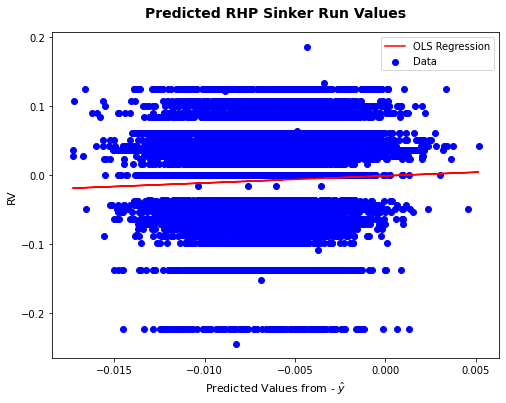

In [21]:
plt.figure(figsize = (8, 6))

plt.scatter(pred_si_r, y_test, c = 'b', marker = 'o', label = 'Data')
plt.plot(pred_si_r, np.poly1d(np.polyfit(pred_si_r, y_test, 1))(pred_si_r), c = 'r', label = 'OLS Regression')
plt.legend()
plt.xlabel('Predicted Values from - $\hat{y}$', fontsize = 11), plt.ylabel('RV', fontsize = 11)
plt.title('Predicted RHP Sinker Run Values', fontsize = 14, fontweight = 'bold', pad = 15);

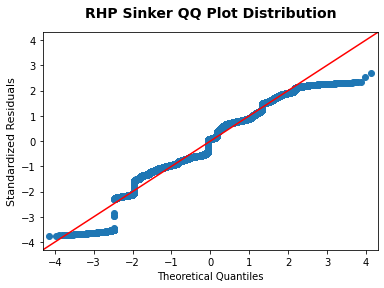

In [22]:
sm.qqplot(residuals_si_r, line = '45', fit = True)
plt.ylabel('Standardized Residuals', fontsize = 11)
plt.title('RHP Sinker QQ Plot Distribution', fontsize = 14, fontweight = 'bold', pad = 15);

## Sinker LHP

In [23]:
features_si_l = si_l.select_dtypes([np.number])
X = features_si_l.drop(columns = ['rv_count'])
X = sm.add_constant(X)
y = features_si_l['rv_count']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 10)

ols_si_l = sm.OLS(y_train, X_train).fit()
pred_si_l = ols_si_l.predict(X_test)
pred = ols_si_l.predict(X_train)
fitted_vals_si_l = ols_si_l.fittedvalues
residuals_si_l = ols_si_l.resid

print('MSE:', round(metrics.mean_squared_error(y_test, pred_si_l), 4))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_si_l)), 4))
print('MAE:', round(metrics.mean_absolute_error(y_test, pred_si_l), 4))
print('Train MSE:', round(metrics.mean_squared_error(y_train, pred), 4))
print('Train RMSE:', round(np.sqrt(metrics.mean_squared_error(y_train, pred)), 4))
print('Train MAE:', round(metrics.mean_absolute_error(y_train, pred), 4))
print(ols_si_l.summary())

MSE: 0.0036
RMSE: 0.0603
MAE: 0.0518
Train MSE: 0.0036
Train RMSE: 0.06
Train MAE: 0.0515
                            OLS Regression Results                            
Dep. Variable:               rv_count   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     8.570
Date:                Wed, 09 Mar 2022   Prob (F-statistic):           6.29e-13
Time:                        14:38:23   Log-Likelihood:                 34986.
No. Observations:               25102   AIC:                        -6.995e+04
Df Residuals:                   25092   BIC:                        -6.987e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------

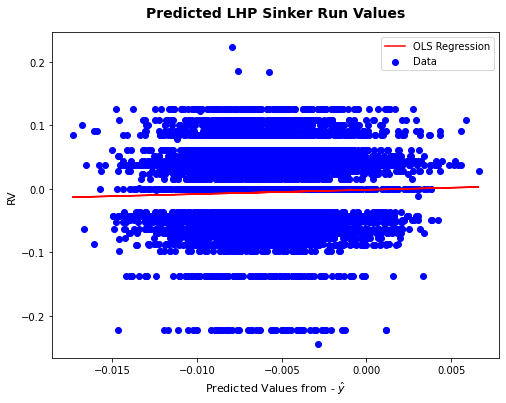

In [24]:
plt.figure(figsize = (8, 6))

plt.scatter(pred_si_l, y_test, c = 'b', marker = 'o', label = 'Data')
plt.plot(pred_si_l, np.poly1d(np.polyfit(pred_si_l, y_test, 1))(pred_si_l), c = 'r', label = 'OLS Regression')
plt.legend()
plt.xlabel('Predicted Values from - $\hat{y}$', fontsize = 11), plt.ylabel('RV', fontsize = 11)
plt.title('Predicted LHP Sinker Run Values', fontsize = 14, fontweight = 'bold', pad = 15);

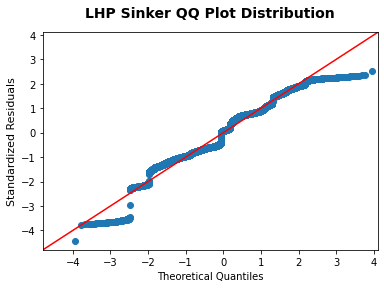

In [25]:
sm.qqplot(residuals_si_l, line = '45', fit = True)
plt.ylabel('Standardized Residuals', fontsize = 11)
plt.title('LHP Sinker QQ Plot Distribution', fontsize = 14, fontweight = 'bold', pad = 15);

## Slider RHP

In [26]:
features_sl_r = sl_r.select_dtypes([np.number])
X = features_sl_r.drop(columns = ['rv_count'])
X = sm.add_constant(X)
y = features_sl_r['rv_count']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 10)

ols_sl_r = sm.OLS(y_train, X_train).fit()
pred_sl_r = ols_sl_r.predict(X_test)
pred = ols_sl_r.predict(X_train)
fitted_vals_sl_r = ols_sl_r.fittedvalues
residuals_sl_r = ols_sl_r.resid

print('MSE:', round(metrics.mean_squared_error(y_test, pred_sl_r), 4))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_sl_r)), 4))
print('MAE:', round(metrics.mean_absolute_error(y_test, pred_sl_r), 4))
print('Train MSE:', round(metrics.mean_squared_error(y_train, pred), 4))
print('Train RMSE:', round(np.sqrt(metrics.mean_squared_error(y_train, pred)), 4))
print('Train MAE:', round(metrics.mean_absolute_error(y_train, pred), 4))
print(ols_sl_r.summary())

MSE: 0.0031
RMSE: 0.0555
MAE: 0.0469
Train MSE: 0.0031
Train RMSE: 0.0555
Train MAE: 0.0471
                            OLS Regression Results                            
Dep. Variable:               rv_count   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     392.7
Date:                Wed, 09 Mar 2022   Prob (F-statistic):               0.00
Time:                        14:38:24   Log-Likelihood:             1.1123e+05
No. Observations:               75569   AIC:                        -2.224e+05
Df Residuals:                   75559   BIC:                        -2.224e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------

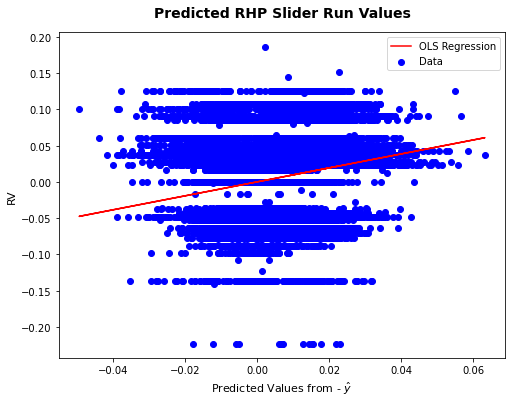

In [27]:
plt.figure(figsize = (8, 6))

plt.scatter(pred_sl_r, y_test, c = 'b', marker = 'o', label = 'Data')
plt.plot(pred_sl_r, np.poly1d(np.polyfit(pred_sl_r, y_test, 1))(pred_sl_r), c = 'r', label = 'OLS Regression')
plt.legend()
plt.xlabel('Predicted Values from - $\hat{y}$', fontsize = 11), plt.ylabel('RV', fontsize = 11)
plt.title('Predicted RHP Slider Run Values', fontsize = 14, fontweight = 'bold', pad = 15);

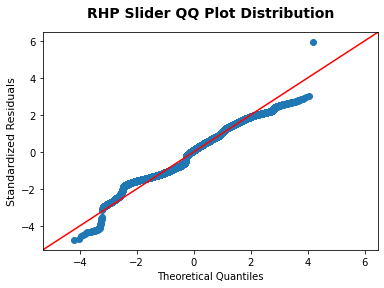

In [28]:
sm.qqplot(residuals_sl_r, line = '45', fit = True)
plt.ylabel('Standardized Residuals', fontsize = 11)
plt.title('RHP Slider QQ Plot Distribution', fontsize = 14, fontweight = 'bold', pad = 15);

## Slider LHP

In [29]:
features_sl_l = sl_l.select_dtypes([np.number])
X = features_sl_l.drop(columns = ['rv_count'])
X = sm.add_constant(X)
y = features_sl_l['rv_count']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 10)

ols_sl_l = sm.OLS(y_train, X_train).fit()
pred_sl_l = ols_sl_l.predict(X_test)
pred = ols_sl_l.predict(X_train)
fitted_vals_sl_l = ols_sl_l.fittedvalues
residuals_sl_l = ols_sl_l.resid

print('MSE:', round(metrics.mean_squared_error(y_test, pred_sl_l), 4))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_sl_l)), 4))
print('MAE:', round(metrics.mean_absolute_error(y_test, pred_sl_l), 4))
print('Train MSE:', round(metrics.mean_squared_error(y_train, pred), 4))
print('Train RMSE:', round(np.sqrt(metrics.mean_squared_error(y_train, pred)), 4))
print('Train MAE:', round(metrics.mean_absolute_error(y_train, pred), 4))
print(ols_sl_l.summary())

MSE: 0.0031
RMSE: 0.0554
MAE: 0.047
Train MSE: 0.0031
Train RMSE: 0.0556
Train MAE: 0.0471
                            OLS Regression Results                            
Dep. Variable:               rv_count   R-squared:                       0.042
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     125.8
Date:                Wed, 09 Mar 2022   Prob (F-statistic):          7.29e-233
Time:                        14:38:24   Log-Likelihood:                 38342.
No. Observations:               26085   AIC:                        -7.666e+04
Df Residuals:                   26075   BIC:                        -7.658e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------

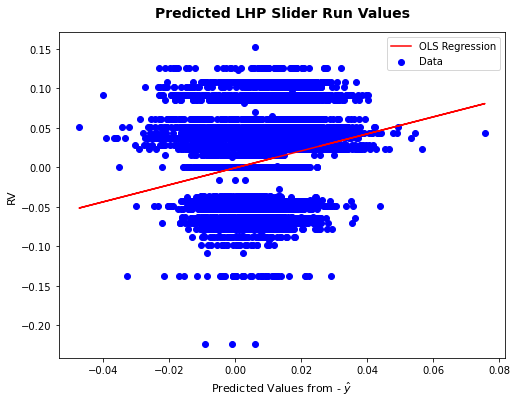

In [30]:
plt.figure(figsize = (8, 6))

plt.scatter(pred_sl_l, y_test, c = 'b', marker = 'o', label = 'Data')
plt.plot(pred_sl_l, np.poly1d(np.polyfit(pred_sl_l, y_test, 1))(pred_sl_l), c = 'r', label = 'OLS Regression')
plt.legend()
plt.xlabel('Predicted Values from - $\hat{y}$', fontsize = 11), plt.ylabel('RV', fontsize = 11)
plt.title('Predicted LHP Slider Run Values', fontsize = 14, fontweight = 'bold', pad = 15);

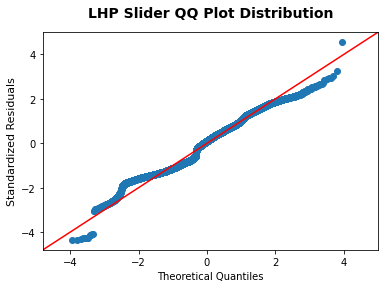

In [31]:
sm.qqplot(residuals_sl_l, line = '45', fit = True)
plt.ylabel('Standardized Residuals', fontsize = 11)
plt.title('LHP Slider QQ Plot Distribution', fontsize = 14, fontweight = 'bold', pad = 15);

## Curveball RHP

In [32]:
features_cu_r = cu_r.select_dtypes([np.number])
X = features_cu_r.drop(columns = ['rv_count'])
X = sm.add_constant(X)
y = features_cu_r['rv_count']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 10)

ols_cu_r = sm.OLS(y_train, X_train).fit()
pred_cu_r = ols_cu_r.predict(X_test)
pred = ols_cu_r.predict(X_train)
fitted_vals_cu_r = ols_cu_r.fittedvalues
residuals_cu_r = ols_cu_r.resid

print('MSE:', round(metrics.mean_squared_error(y_test, pred_cu_r), 4))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_cu_r)), 4))
print('MAE:', round(metrics.mean_absolute_error(y_test, pred_cu_r), 4))
print('Train MSE:', round(metrics.mean_squared_error(y_train, pred), 4))
print('Train RMSE:', round(np.sqrt(metrics.mean_squared_error(y_train, pred)), 4))
print('Train MAE:', round(metrics.mean_absolute_error(y_train, pred), 4))
print(ols_cu_r.summary())

MSE: 0.0028
RMSE: 0.0525
MAE: 0.0448
Train MSE: 0.0028
Train RMSE: 0.0529
Train MAE: 0.045
                            OLS Regression Results                            
Dep. Variable:               rv_count   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     119.2
Date:                Wed, 09 Mar 2022   Prob (F-statistic):          3.91e-221
Time:                        14:38:25   Log-Likelihood:                 45618.
No. Observations:               29991   AIC:                        -9.122e+04
Df Residuals:                   29981   BIC:                        -9.113e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------

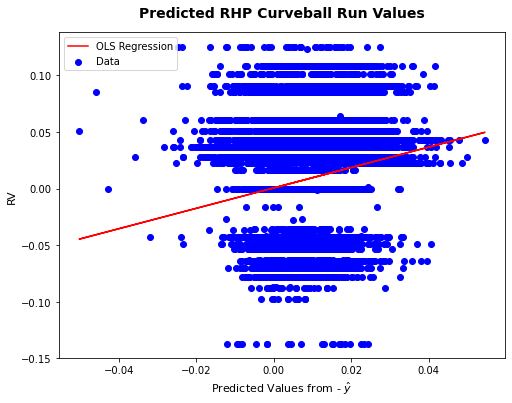

In [33]:
plt.figure(figsize = (8, 6))

plt.scatter(pred_cu_r, y_test, c = 'b', marker = 'o', label = 'Data')
plt.plot(pred_cu_r, np.poly1d(np.polyfit(pred_cu_r, y_test, 1))(pred_cu_r), c = 'r', label = 'OLS Regression')
plt.legend()
plt.xlabel('Predicted Values from - $\hat{y}$', fontsize = 11), plt.ylabel('RV', fontsize = 11)
plt.title('Predicted RHP Curveball Run Values', fontsize = 14, fontweight = 'bold', pad = 15);

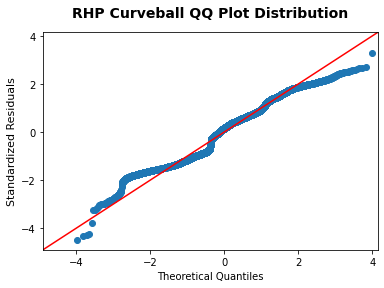

In [34]:
sm.qqplot(residuals_cu_r, line='45', fit=True)
plt.ylabel('Standardized Residuals', fontsize = 11)
plt.title('RHP Curveball QQ Plot Distribution', fontsize = 14, fontweight = 'bold', pad = 15);

## Curveball LHP

In [35]:
features_cu_l = cu_l.select_dtypes([np.number])
X = features_cu_l.drop(columns = ['rv_count'])
X = sm.add_constant(X)
y = features_cu_l['rv_count']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 10)

ols_cu_l = sm.OLS(y_train, X_train).fit()
pred_cu_l = ols_cu_l.predict(X_test)
pred = ols_cu_l.predict(X_train)
fitted_vals_cu_l = ols_cu_l.fittedvalues
residuals_cu_l = ols_cu_l.resid

print('MSE:', round(metrics.mean_squared_error(y_test, pred_cu_l), 4))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_cu_l)), 4))
print('MAE:', round(metrics.mean_absolute_error(y_test, pred_cu_l), 4))
print('Train MSE:', round(metrics.mean_squared_error(y_train, pred), 4))
print('Train RMSE:', round(np.sqrt(metrics.mean_squared_error(y_train, pred)), 4))
print('Train MAE:', round(metrics.mean_absolute_error(y_train, pred), 4))
print(ols_cu_l.summary())

MSE: 0.0028
RMSE: 0.0527
MAE: 0.0447
Train MSE: 0.0028
Train RMSE: 0.0531
Train MAE: 0.0451
                            OLS Regression Results                            
Dep. Variable:               rv_count   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     48.00
Date:                Wed, 09 Mar 2022   Prob (F-statistic):           4.73e-86
Time:                        14:38:25   Log-Likelihood:                 21360.
No. Observations:               14084   AIC:                        -4.270e+04
Df Residuals:                   14074   BIC:                        -4.262e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------

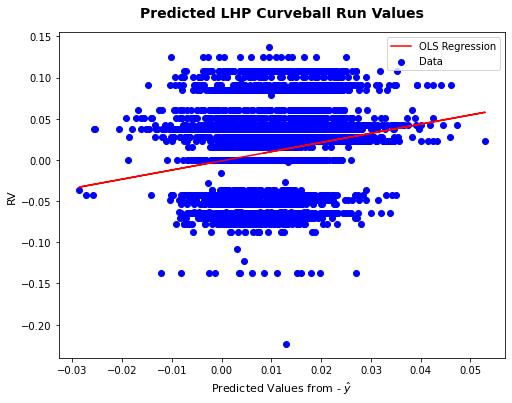

In [36]:
plt.figure(figsize = (8, 6))

plt.scatter(pred_cu_l, y_test, c = 'b', marker = 'o', label = 'Data')
plt.plot(pred_cu_l, np.poly1d(np.polyfit(pred_cu_l, y_test, 1))(pred_cu_l), c = 'r', label = 'OLS Regression')
plt.legend()
plt.xlabel('Predicted Values from - $\hat{y}$', fontsize = 11), plt.ylabel('RV', fontsize = 11)
plt.title('Predicted LHP Curveball Run Values', fontsize = 14, fontweight = 'bold', pad = 15);

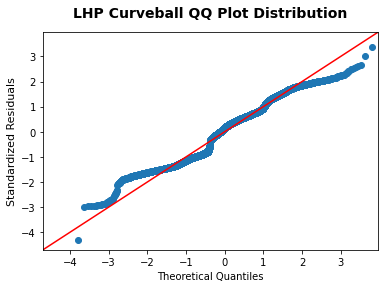

In [37]:
sm.qqplot(residuals_cu_l, line='45', fit=True)
plt.ylabel('Standardized Residuals', fontsize = 11)
plt.title('LHP Curveball QQ Plot Distribution', fontsize = 14, fontweight = 'bold', pad = 15);

## Changeup RHP

In [38]:
features_ch_r = ch_r.select_dtypes([np.number])
X = features_ch_r.drop(columns = ['rv_count'])
X = sm.add_constant(X)
y = features_ch_r['rv_count']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 10)

ols_ch_r = sm.OLS(y_train, X_train).fit()
pred_ch_r = ols_ch_r.predict(X_test)
pred = ols_ch_r.predict(X_train)
fitted_vals_ch_r = ols_ch_r.fittedvalues
residuals_ch_r = ols_ch_r.resid

print('MSE:', round(metrics.mean_squared_error(y_test, pred_ch_r), 4))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_ch_r)), 4))
print('MAE:', round(metrics.mean_absolute_error(y_test, pred_ch_r), 4))
print('Train MSE:', round(metrics.mean_squared_error(y_train, pred), 4))
print('Train RMSE:', round(np.sqrt(metrics.mean_squared_error(y_train, pred)), 4))
print('Train MAE:', round(metrics.mean_absolute_error(y_train, pred), 4))
print(ols_ch_r.summary())

MSE: 0.0032
RMSE: 0.0562
MAE: 0.0475
Train MSE: 0.0032
Train RMSE: 0.0565
Train MAE: 0.0479
                            OLS Regression Results                            
Dep. Variable:               rv_count   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                  0.042
Method:                 Least Squares   F-statistic:                     187.9
Date:                Wed, 09 Mar 2022   Prob (F-statistic):               0.00
Time:                        14:38:25   Log-Likelihood:                 55228.
No. Observations:               37989   AIC:                        -1.104e+05
Df Residuals:                   37979   BIC:                        -1.104e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------

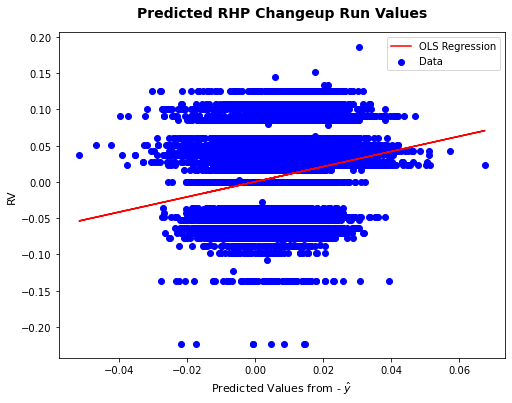

In [39]:
plt.figure(figsize = (8, 6))
plt.scatter(pred_ch_r, y_test, c = 'b', marker = 'o', label = 'Data')
plt.plot(pred_ch_r, np.poly1d(np.polyfit(pred_ch_r, y_test, 1))(pred_ch_r), c = 'r', label = 'OLS Regression')
plt.legend()
plt.xlabel('Predicted Values from - $\hat{y}$', fontsize = 11), plt.ylabel('RV', fontsize = 11)
plt.title('Predicted RHP Changeup Run Values', fontsize = 14, fontweight = 'bold', pad = 15);

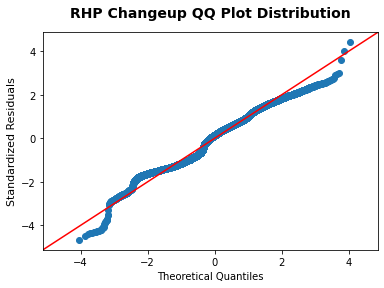

In [40]:
sm.qqplot(residuals_ch_r, line = '45', fit = True)
plt.ylabel('Standardized Residuals', fontsize = 11)
plt.title('RHP Changeup QQ Plot Distribution', fontsize = 14, fontweight = 'bold', pad = 15);

## Changeup LHP

In [41]:
features_ch_l = ch_l.select_dtypes([np.number])
X = features_ch_l.drop(columns = ['rv_count'])
X = sm.add_constant(X)
y = features_ch_l['rv_count']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 10)

ols_ch_l = sm.OLS(y_train, X_train).fit()
pred_ch_l = ols_ch_l.predict(X_test)
pred = ols_ch_l.predict(X_train)
fitted_vals_ch_l = ols_ch_l.fittedvalues
residuals_ch_l = ols_ch_l.resid

print('MSE:', round(metrics.mean_squared_error(y_test, pred_ch_l), 4))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_ch_l)), 4))
print('MAE:', round(metrics.mean_absolute_error(y_test, pred_ch_l), 4))
print('Train MSE:', round(metrics.mean_squared_error(y_train, pred), 4))
print('Train RMSE:', round(np.sqrt(metrics.mean_squared_error(y_train, pred)), 4))
print('Train MAE:', round(metrics.mean_absolute_error(y_train, pred), 4))
print(ols_ch_l.summary())

MSE: 0.0031
RMSE: 0.0557
MAE: 0.0465
Train MSE: 0.0031
Train RMSE: 0.0555
Train MAE: 0.0466
                            OLS Regression Results                            
Dep. Variable:               rv_count   R-squared:                       0.061
Model:                            OLS   Adj. R-squared:                  0.060
Method:                 Least Squares   F-statistic:                     159.4
Date:                Wed, 09 Mar 2022   Prob (F-statistic):          9.78e-294
Time:                        14:38:26   Log-Likelihood:                 32778.
No. Observations:               22251   AIC:                        -6.554e+04
Df Residuals:                   22241   BIC:                        -6.546e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------

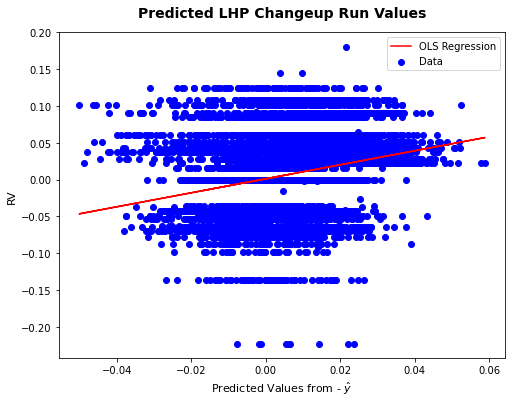

In [42]:
plt.figure(figsize = (8, 6))
plt.scatter(pred_ch_l, y_test, c = 'b', marker = 'o', label = 'Data')
plt.plot(pred_ch_l, np.poly1d(np.polyfit(pred_ch_l, y_test, 1))(pred_ch_l), c = 'r', label = 'OLS Regression')
plt.legend()
plt.xlabel('Predicted Values from - $\hat{y}$', fontsize = 11), plt.ylabel('RV', fontsize = 11)
plt.title('Predicted LHP Changeup Run Values', fontsize = 14, fontweight = 'bold', pad = 15);

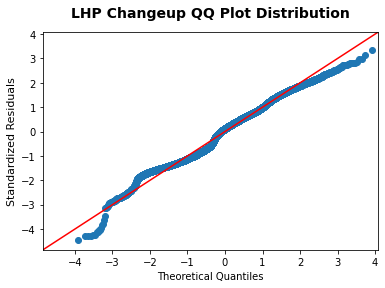

In [43]:
sm.qqplot(residuals_ch_l, line = '45', fit = True)
plt.ylabel('Standardized Residuals', fontsize = 11)
plt.title('LHP Changeup QQ Plot Distribution', fontsize = 14, fontweight = 'bold', pad = 15);

# Grouped Pitches

## Fastball RHP

#### 4-Seam, Cutter, Sinker

In [44]:
features_fastball_r = rhp_fastball.select_dtypes([np.number])
X = features_fastball_r.drop(columns = ['rv_count'])
X = sm.add_constant(X)
y = features_fastball_r['rv_count']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 10)

ols_fastball_r = sm.OLS(y_train, X_train).fit()
pred_fastball_r = ols_fastball_r.predict(X_test)
fitted_vals_fastball_r = ols_fastball_r.fittedvalues
residuals_fastball_r = ols_fastball_r.resid

print('MSE:', round(metrics.mean_squared_error(y_test, pred_fastball_r), 4))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_fastball_r)), 4))
print('MAE:', round(metrics.mean_absolute_error(y_test, pred_fastball_r), 4))
print(ols_fastball_r.summary())

MSE: 0.0036
RMSE: 0.06
MAE: 0.0512
                            OLS Regression Results                            
Dep. Variable:               rv_count   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     194.6
Date:                Wed, 09 Mar 2022   Prob (F-statistic):               0.00
Time:                        14:38:26   Log-Likelihood:             2.9544e+05
No. Observations:              212418   AIC:                        -5.909e+05
Df Residuals:                  212408   BIC:                        -5.908e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
con

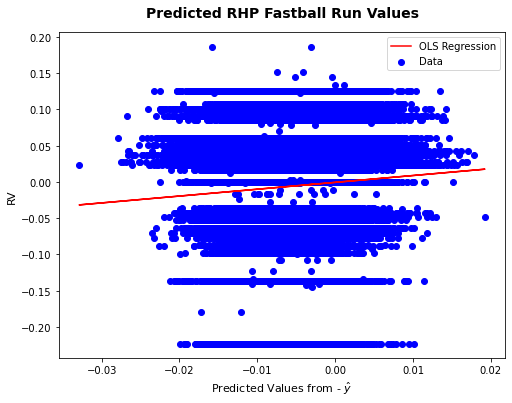

In [45]:
plt.figure(figsize = (8, 6))
plt.scatter(pred_fastball_r, y_test, c = 'b', marker = 'o', label = 'Data')
plt.plot(pred_fastball_r, np.poly1d(np.polyfit(pred_fastball_r, y_test, 1))(pred_fastball_r), c = 'r',
         label = 'OLS Regression')
plt.legend()
plt.xlabel('Predicted Values from - $\hat{y}$', fontsize = 11), plt.ylabel('RV', fontsize = 11)
plt.title('Predicted RHP Fastball Run Values', fontsize = 14, fontweight = 'bold', pad = 15);

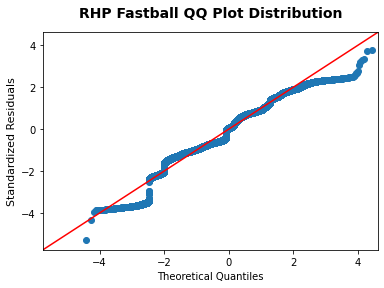

In [46]:
sm.qqplot(residuals_fastball_r, line = '45', fit = True)
plt.ylabel('Standardized Residuals', fontsize = 11)
plt.title('RHP Fastball QQ Plot Distribution', fontsize = 14, fontweight = 'bold', pad = 15);

## Fastball LHP

#### 4-Seam, Cutter, Sinker

In [47]:
features_fastball_l = lhp_fastball.select_dtypes([np.number])
X = features_fastball_l.drop(columns = ['rv_count'])
X = sm.add_constant(X)
y = features_fastball_l['rv_count']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 10)

ols_fastball_l = sm.OLS(y_train, X_train).fit()
pred_fastball_l = ols_fastball_l.predict(X_test)
fitted_vals_fastball_l = ols_fastball_l.fittedvalues
residuals_fastball_l = ols_fastball_l.resid

print('MSE:', round(metrics.mean_squared_error(y_test, pred_fastball_l), 4))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_fastball_l)), 4))
print('MAE:', round(metrics.mean_absolute_error(y_test, pred_fastball_l), 4))
print(ols_fastball_l.summary())

MSE: 0.0036
RMSE: 0.0601
MAE: 0.0512
                            OLS Regression Results                            
Dep. Variable:               rv_count   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     68.98
Date:                Wed, 09 Mar 2022   Prob (F-statistic):          1.97e-127
Time:                        14:38:27   Log-Likelihood:             1.2839e+05
No. Observations:               92276   AIC:                        -2.568e+05
Df Residuals:                   92266   BIC:                        -2.567e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
c

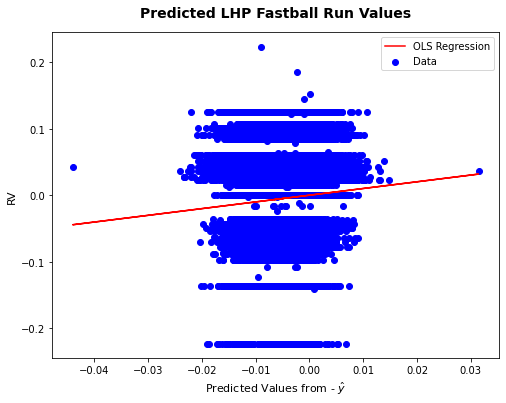

In [48]:
plt.figure(figsize = (8, 6))
plt.scatter(pred_fastball_l, y_test, c = 'b', marker = 'o', label = 'Data')
plt.plot(pred_fastball_l, np.poly1d(np.polyfit(pred_fastball_l, y_test, 1))(pred_fastball_l), c = 'r', 
         label = 'OLS Regression')
plt.legend()
plt.xlabel('Predicted Values from - $\hat{y}$', fontsize = 11), plt.ylabel('RV', fontsize = 11)
plt.title('Predicted LHP Fastball Run Values', fontsize = 14, fontweight = 'bold', pad = 15);

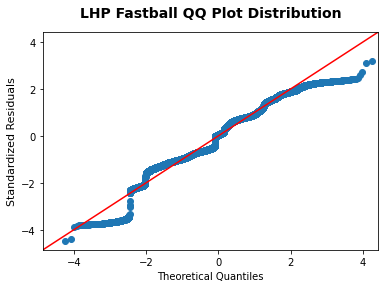

In [49]:
sm.qqplot(residuals_fastball_l, line = '45', fit = True)
plt.ylabel('Standardized Residuals', fontsize = 11)
plt.title('LHP Fastball QQ Plot Distribution', fontsize = 14, fontweight = 'bold', pad = 15);

## Breaking Ball RHP

#### Slider, Curveball, Knuckle Curve

In [50]:
features_bb_r = rhp_breaking_ball.select_dtypes([np.number])
X = features_bb_r.drop(columns = ['rv_count'])
X = sm.add_constant(X)
y = features_bb_r['rv_count']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 10)

ols_bb_r = sm.OLS(y_train, X_train).fit()
pred_bb_r = ols_bb_r.predict(X_test)
fitted_vals_bb_r = ols_bb_r.fittedvalues
residuals_bb_r = ols_bb_r.resid

print('MSE:', round(metrics.mean_squared_error(y_test, pred_bb_r), 4))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_bb_r)), 4))
print('MAE:', round(metrics.mean_absolute_error(y_test, pred_bb_r), 4))
print(ols_bb_r.summary())

MSE: 0.003
RMSE: 0.0548
MAE: 0.0465
                            OLS Regression Results                            
Dep. Variable:               rv_count   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     494.4
Date:                Wed, 09 Mar 2022   Prob (F-statistic):               0.00
Time:                        14:38:28   Log-Likelihood:             1.6977e+05
No. Observations:              114287   AIC:                        -3.395e+05
Df Residuals:                  114277   BIC:                        -3.394e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
co

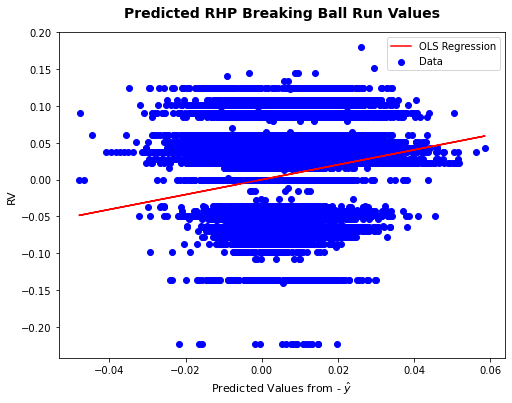

In [51]:
plt.figure(figsize = (8, 6))
plt.scatter(pred_bb_r, y_test, c = 'b', marker = 'o', label = 'Data')
plt.plot(pred_bb_r, np.poly1d(np.polyfit(pred_bb_r, y_test, 1))(pred_bb_r), c = 'r', label = 'OLS Regression')
plt.legend()
plt.xlabel('Predicted Values from - $\hat{y}$', fontsize = 11), plt.ylabel('RV', fontsize = 11)
plt.title('Predicted RHP Breaking Ball Run Values', fontsize = 14, fontweight = 'bold', pad = 15);

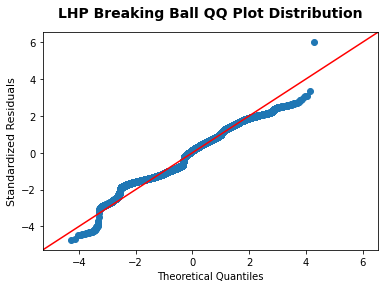

In [52]:
sm.qqplot(residuals_bb_r, line = '45', fit = True)
plt.ylabel('Standardized Residuals', fontsize = 11)
plt.title('LHP Breaking Ball QQ Plot Distribution', fontsize = 14, fontweight = 'bold', pad = 15);

## Breaking Ball LHP

#### Slider, Curveball, Knuckle Curve

In [53]:
features_bb_l = lhp_breaking_ball.select_dtypes([np.number])
X = features_bb_l.drop(columns = ['rv_count'])
X = sm.add_constant(X)
y = features_bb_l['rv_count']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 10)

ols_bb_l = sm.OLS(y_train, X_train).fit()
pred_bb_l = ols_bb_l.predict(X_test)
fitted_vals_bb_l = ols_bb_l.fittedvalues
residuals_bb_l = ols_bb_l.resid

print('MSE:', round(metrics.mean_squared_error(y_test, pred_bb_l), 4))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_bb_l)), 4))
print('MAE:', round(metrics.mean_absolute_error(y_test, pred_bb_l), 4))
print(ols_bb_l.summary())

MSE: 0.003
RMSE: 0.0545
MAE: 0.0464
                            OLS Regression Results                            
Dep. Variable:               rv_count   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     175.6
Date:                Wed, 09 Mar 2022   Prob (F-statistic):               0.00
Time:                        14:38:28   Log-Likelihood:                 61949.
No. Observations:               41699   AIC:                        -1.239e+05
Df Residuals:                   41689   BIC:                        -1.238e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
co

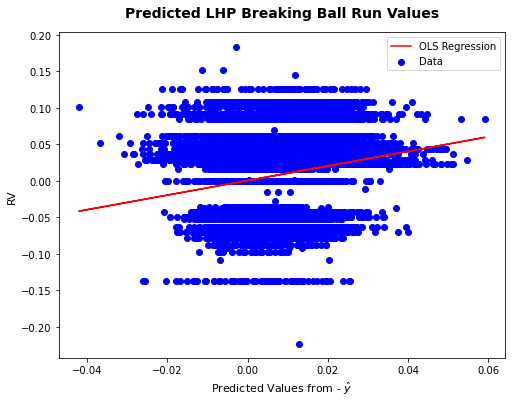

In [54]:
plt.figure(figsize = (8, 6))
plt.scatter(pred_bb_l, y_test, c = 'b', marker = 'o', label = 'Data')
plt.plot(pred_bb_l, np.poly1d(np.polyfit(pred_bb_l, y_test, 1))(pred_bb_l), c = 'r', label = 'OLS Regression')
plt.legend()
plt.xlabel('Predicted Values from - $\hat{y}$', fontsize = 11), plt.ylabel('RV', fontsize = 11)
plt.title('Predicted LHP Breaking Ball Run Values', fontsize = 14, fontweight = 'bold', pad = 15);

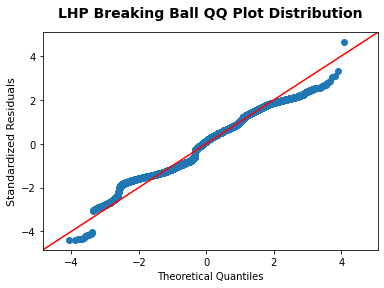

In [55]:
sm.qqplot(residuals_bb_l, line = '45', fit = True)
plt.ylabel('Standardized Residuals', fontsize = 11)
plt.title('LHP Breaking Ball QQ Plot Distribution', fontsize = 14, fontweight = 'bold', pad = 15);

## Off-speed RHP

#### Changeup, Splitter

In [56]:
features_os_r = rhp_offspeed.select_dtypes([np.number])
X = features_os_r.drop(columns = ['rv_count'])
X = sm.add_constant(X)
y = features_os_r['rv_count']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 10)

ols_os_r = sm.OLS(y_train, X_train).fit()
pred_os_r = ols_os_r.predict(X_test)
fitted_vals_os_r = ols_os_r.fittedvalues
residuals_os_r = ols_os_r.resid

print('MSE:', round(metrics.mean_squared_error(y_test, pred_os_r), 4))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_os_r)), 4))
print('MAE:', round(metrics.mean_absolute_error(y_test, pred_os_r), 4))
print(ols_os_r.summary())

MSE: 0.0032
RMSE: 0.0563
MAE: 0.0477
                            OLS Regression Results                            
Dep. Variable:               rv_count   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     218.5
Date:                Wed, 09 Mar 2022   Prob (F-statistic):               0.00
Time:                        14:38:29   Log-Likelihood:                 66491.
No. Observations:               45668   AIC:                        -1.330e+05
Df Residuals:                   45658   BIC:                        -1.329e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
c

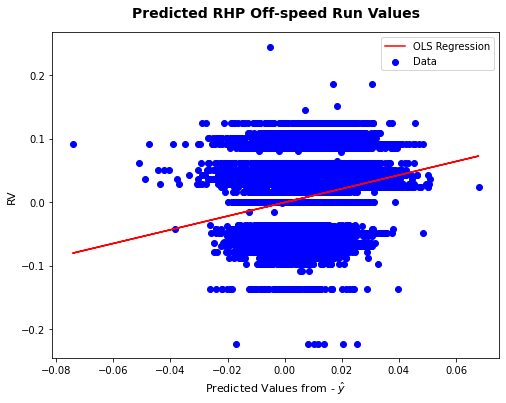

In [57]:
plt.figure(figsize = (8, 6))
plt.scatter(pred_os_r, y_test, c = 'b', marker = 'o', label = 'Data')
plt.plot(pred_os_r, np.poly1d(np.polyfit(pred_os_r, y_test, 1))(pred_os_r), c = 'r', label = 'OLS Regression')
plt.legend()
plt.xlabel('Predicted Values from - $\hat{y}$', fontsize = 11), plt.ylabel('RV', fontsize = 11)
plt.title('Predicted RHP Off-speed Run Values', fontsize = 14, fontweight = 'bold', pad = 15);

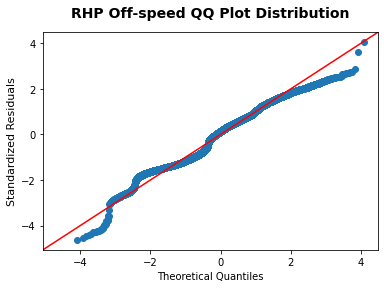

In [58]:
sm.qqplot(residuals_os_r, line = '45', fit = True)
plt.ylabel('Standardized Residuals', fontsize = 11)
plt.title('RHP Off-speed QQ Plot Distribution', fontsize = 14, fontweight = 'bold', pad = 15);

## Off-speed LHP

#### Changeup, Splitter

In [59]:
features_os_l = lhp_offspeed.select_dtypes([np.number])
X = features_os_l.drop(columns = ['rv_count'])
X = sm.add_constant(X)
y = features_os_l['rv_count']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 10)

ols_os_l = sm.OLS(y_train, X_train).fit()
pred_os_l = ols_os_l.predict(X_test)
fitted_vals_os_l = ols_os_l.fittedvalues
residuals_os_l = ols_os_l.resid

print('MSE:', round(metrics.mean_squared_error(y_test, pred_os_l), 4))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_os_l)), 4))
print('MAE:', round(metrics.mean_absolute_error(y_test, pred_os_l), 4))
print(ols_os_l.summary())

MSE: 0.0031
RMSE: 0.0557
MAE: 0.0466
                            OLS Regression Results                            
Dep. Variable:               rv_count   R-squared:                       0.060
Model:                            OLS   Adj. R-squared:                  0.060
Method:                 Least Squares   F-statistic:                     160.9
Date:                Wed, 09 Mar 2022   Prob (F-statistic):          9.29e-297
Time:                        14:38:29   Log-Likelihood:                 33415.
No. Observations:               22703   AIC:                        -6.681e+04
Df Residuals:                   22693   BIC:                        -6.673e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
c

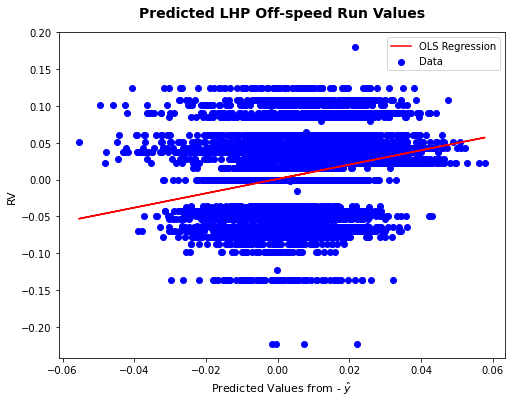

In [60]:
plt.figure(figsize = (8, 6))
plt.scatter(pred_os_l, y_test, c = 'b', marker = 'o', label = 'Data')
plt.plot(pred_os_l, np.poly1d(np.polyfit(pred_os_l, y_test, 1))(pred_os_l), c = 'r', label = 'OLS Regression')
plt.legend()
plt.xlabel('Predicted Values from - $\hat{y}$', fontsize = 11), plt.ylabel('RV', fontsize = 11)
plt.title('Predicted LHP Off-speed Run Values', fontsize = 14, fontweight = 'bold', pad = 15);

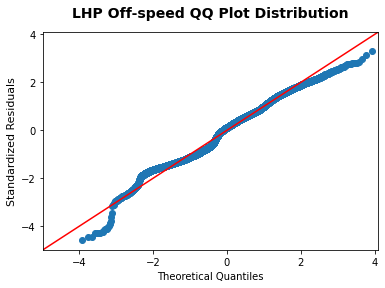

In [61]:
sm.qqplot(residuals_os_l, line = '45', fit = True)
plt.ylabel('Standardized Residuals', fontsize = 11)
plt.title('LHP Off-speed QQ Plot Distribution', fontsize = 14, fontweight = 'bold', pad = 15);